## Framing the Objective
- **PM’s Objective** : Does ridership increase on working days during early evening (5–7pm) after launching a small app feature? 
    - So we’re testing whether the “Post-launch” period shows more rides/hour than the “Pre-launch” period.

### Step 2: Define Metric & Eligibility
- **Primary Metric**: Average hourly rides (cnt) during 17:00–19:00 (5–7pm) on working days when weather is good.
- Eligibility Filters (keep only rows where):
    - workingday == 1
    - hr E {17,18,19}
    - weathersit ∈ {1,2} (clear/mist)
    - hum <= 0.70

### Step 3: Define Windows (Pretend Launch Date)
- Pre (Baseline): 2012-08-04 -> 2012-08-31
- Post (Feature On): 2012-09-01 -> 2012-09-28

### Step 4: Build Groups A vs B
- Group A = Pre rows (after filtering)
- Group B = Post rows (after filtering)
- Balance check: For each weekday x hour, make sure group A and B have the same number of rows (truncate to smaller count).

### Step 5: Run Test
- Null Hypothesis H₀: No difference in average rides/hour between Pre and Post.
- Alternative H₁: Post > Pre (one-sided or two-sided depending on setup).
- Use a t-test (independent samples, Welch’s).
- Report: t-statistic, p-value, 95% CI.
- Practical significance: e.g., +5 rides/hour is the meaningful threshold.

### Step 6: check guardrails
- the guardrail is my “final sanity check” step, right before the PM recommendation

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import t


In [3]:
df = pd.read_csv('/Users/ayemaq/Desktop/Mod4_prj/dataset/hour.csv')

In [4]:
# Step 1: Apply eligibility filters
eligible = df[
    (df['workingday'] == 1) &
    (df['hr'].isin([17, 18, 19])) &
    (df['weathersit'].isin([1, 2])) &
    (df['hum'] <= 0.70)
]

# quick sanity check
print(eligible.shape)
eligible.head()

'''
- creates a filtered dataset called eligible
- keeps only rows that meet all conditions
- prints out how many rows are left, so i know my data size after filtering
'''

(1165, 17)


'\n- creates a filtered dataset called eligible\n- keeps only rows that meet all conditions\n- prints out how many rows are left, so i know my data size after filtering\n'

In [5]:
# Step 2: Define windows
pre = eligible[(eligible['dteday'] >= '2012-08-04') & (eligible['dteday'] <= '2012-08-31')]
post = eligible[(eligible['dteday'] >= '2012-09-01') & (eligible['dteday'] <= '2012-09-28')]
print("Pre window: ", pre.shape)
print("Post window: ", post.shape)

pre.head(), post.head()
# splits eligible into pre and post groups by date
# prints out how many rows are in each group

Pre window:  (53, 17)
Post window:  (48, 17)


(       instant      dteday  season  yr  mnth  hr  holiday  weekday  \
 13884    13885  2012-08-06       3   1     8  17        0        1   
 13885    13886  2012-08-06       3   1     8  18        0        1   
 13886    13887  2012-08-06       3   1     8  19        0        1   
 13908    13909  2012-08-07       3   1     8  17        0        2   
 13909    13910  2012-08-07       3   1     8  18        0        2   
 
        workingday  weathersit  temp   atemp   hum  windspeed  casual  \
 13884           1           1  0.82  0.7424  0.41     0.0000     112   
 13885           1           1  0.82  0.7424  0.41     0.1343     100   
 13886           1           1  0.78  0.7424  0.59     0.1940     109   
 13908           1           2  0.78  0.7424  0.62     0.1343     125   
 13909           1           2  0.76  0.7121  0.62     0.1642     103   
 
        registered  cnt  
 13884         746  858  
 13885         743  843  
 13886         531  640  
 13908         743  868  
 1

In [6]:
# Step 3: Balance check (weekday x hour combos)
# First count rows in each group
pre_counts = pre.groupby(['weekday','hr']).size()
post_counts = post.groupby(['weekday','hr']).size()

print("Pre counts:", pre_counts)
print("Post counts:", post_counts)

Pre counts: weekday  hr
1        17    4
         18    3
         19    3
2        17    3
         18    4
         19    3
3        17    3
         18    3
         19    3
4        17    4
         18    4
         19    4
5        17    4
         18    4
         19    4
dtype: int64
Post counts: weekday  hr
1        17    3
         18    2
         19    2
2        17    3
         18    2
         19    3
3        17    4
         18    3
         19    4
4        17    4
         18    4
         19    3
5        17    4
         18    4
         19    3
dtype: int64


In [7]:
balanced = []
for (wd, hr), pre_n in pre_counts.items():
    post_n = post_counts.get((wd, hr), 0)  #0 if missing
    min_n = min(pre_n, post_n)
    if min_n > 0:
        pre_sample = pre[(pre['weekday']==wd) & (pre['hr']==hr)].sample(min_n, random_state=42)
        post_sample = post[(post['weekday']==wd) & (post['hr']==hr)].sample(min_n, random_state=42)
        balanced.append(pre_sample)
        balanced.append(post_sample)

balanced_df = pd.concat(balanced)

print("Balanced dataset:", balanced_df.shape)
balanced_df['dteday'].min(), balanced_df['dteday'].max()


Balanced dataset: (92, 17)


('2012-08-06', '2012-09-28')

In [8]:
# run the t-test

# split the balanced dataset back into pre and post groups
pre_bal = balanced_df[balanced_df['dteday'] <= '2012-08-31']['cnt']
post_bal = balanced_df[balanced_df['dteday'] >= '2012-09-01']['cnt']

# run Welch’s t-test (doesnt assume equal variance REMEMBER)
t_stat, p_val = stats.ttest_ind(post_bal, pre_bal, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", p_val)

# mean diff and 95% CI
mean_diff = post_bal.mean() - pre_bal.mean()
se_diff = np.sqrt(pre_bal.var()/len(pre_bal) + post_bal.var()/len(post_bal))
ci_low = mean_diff - 1.96 * se_diff
ci_high = mean_diff + 1.96 * se_diff

print("Mean difference:", mean_diff)
print("95% CI:", (ci_low, ci_high))


T-statistic: 1.567207327368898
P-value: 0.12060360760962667
Mean difference: 43.78260869565224
95% CI: (-10.9733330006815, 98.53855039198598)


Statistically: no significant evidence the feature increased ridership.

Practically: Even though the mean was +44 rides/hour, the uncertainty is too wide, we can’t be confident it’s a real lift.

PM Recommendation: don’t roll out just yet because we need more data or a longer test window.
- In plain english... don’t roll out yet. The numbers look promising (+44 rides/hour), but they aren’t statistically reliable. Let’s extend the test to gather more data so we can reduce uncertainty

In [9]:
# guardrail for weekends (use original df, not eligible) earlier I was lost because I used eligible LOL
weekend = df[df['workingday'] == 0]

weekend_pre = weekend[(weekend['dteday'] >= '2012-08-04') & (weekend['dteday'] <= '2012-08-31')]['cnt'].mean()
weekend_post = weekend[(weekend['dteday'] >= '2012-09-01') & (weekend['dteday'] <= '2012-09-28')]['cnt'].mean()

print("Weekend Pre avg:", weekend_pre) # before the pretend launch (Aug 4–31), on weekends, riders averaged ~254 rides per hour
print("Weekend Post avg:", weekend_post) # after the launch (Sep 1–28), on weekends, riders averaged ~299 rides per hour
print("Difference:", weekend_post - weekend_pre) # that’s ~44 more rides/hour on weekends in the Post period compared to Pre


Weekend Pre avg: 254.44270833333334
Weekend Post avg: 298.77777777777777
Difference: 44.33506944444443


used weekend ridership as a guardrail. Pre-launch weekends averaged ~254 rides/hour, and Post-launch weekends averaged ~299 rides/hour (+44). This suggests no negative impact on weekends, which is encouraging for overall demand

In [10]:
# some other guardrail metrics i'd like to run is an equity check for casual vs registered riders 
cas_reg_pre = pre[['casual','registered']].mean()
cas_reg_post = post[['casual','registered']].mean()

print("Pre averages:\n", cas_reg_pre)
print("\nPost averages:\n", cas_reg_post)
print("\nDifferences:\n", cas_reg_post - cas_reg_pre)


Pre averages:
 casual        102.698113
registered    636.320755
dtype: float64

Post averages:
 casual         87.145833
registered    699.750000
dtype: float64

Differences:
 casual       -15.552280
registered    63.429245
dtype: float64


Pre averages (before feature launch):
- Casual: 102.7 rides/hour
- Registered: 636.3 rides/hour

Post averages (after feature launch):
- Casual: 87.1 rides/hour
- Registered: 699.8 rides/hour

So actually for casual: –15.6 rides/hour (casual riders actually dropped after the launch) and Registered: +63.4 rides/hour (registered riders increased after the launch)

Hmm, this means that the new feature seems to have benefited registered riders more 
- they’re taking ~63 more rides/hour after launch.
- Casual riders dropped slightly (about –16 rides/hour), so the feature might not appeal to tourists/occasional users.

As a guardrail metric, this tells the PM:
- don’t ignore casuals — the feature is boosting loyal members, but it may discourage new/occasional riders.

In [11]:
# lets also check hour peaks for ops because
# they should care for teams if the demand spikes too much, this cna strain staff, so its good to be prepared 
pre_var = pre['cnt'].var()
post_var = post['cnt'].var()

print("Pre variance:", pre_var)
print("Post variance:", post_var)
print("Difference:", post_var - pre_var)


Pre variance: 16702.67271407837
Post variance: 19591.54210992908
Difference: 2888.86939585071


basically, after launch, demand got a little spikier. Ops teams should be aware that peaks are more intense now, even if average ridership isn’t statistically significantly higher

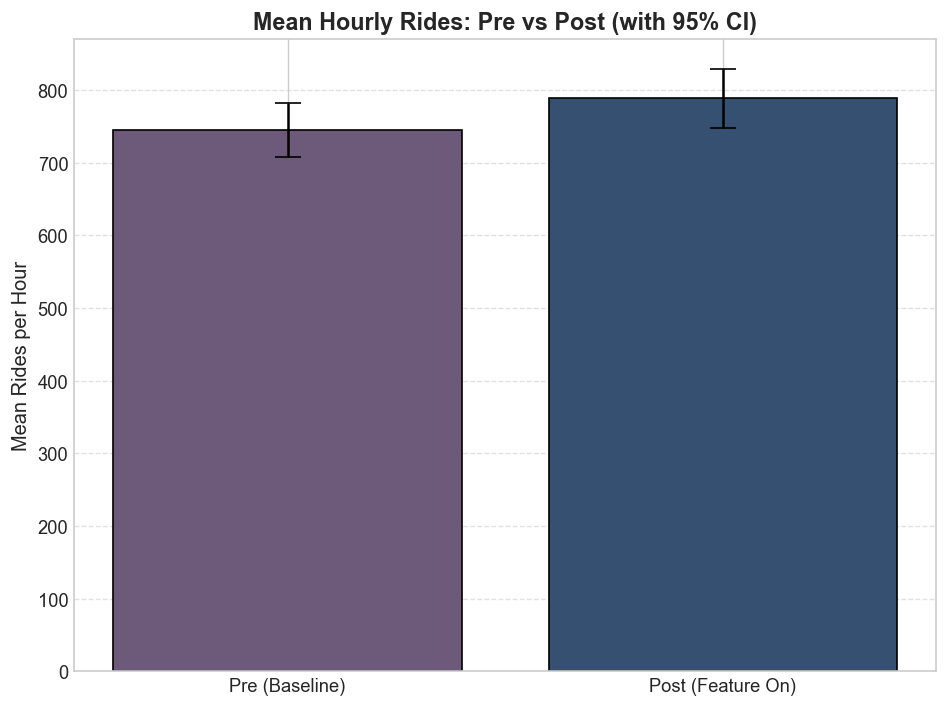

In [ ]:
import matplotlib.pyplot as plt

# Calculate means
pre_mean = pre_bal.mean()
post_mean = post_bal.mean()

# CI bounds (95%)
pre_ci_low, pre_ci_high = pre_mean - 1.96 * pre_bal.std()/np.sqrt(len(pre_bal)), pre_mean + 1.96 * pre_bal.std()/np.sqrt(len(pre_bal))
post_ci_low, post_ci_high = post_mean - 1.96 * post_bal.std()/np.sqrt(len(post_bal)), post_mean + 1.96 * post_bal.std()/np.sqrt(len(post_bal))

# Heights of bars
means = [pre_mean, post_mean]

# Error bar lengths
errors = [
    [pre_mean - pre_ci_low, post_mean - post_ci_low], 
    [pre_ci_high - pre_mean, post_ci_high - post_mean]
]

# Plot
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(8,6), dpi=120)

plt.bar(
    ["Pre (Baseline)", "Post (Feature On)"], 
    means,
    yerr=errors, 
    capsize=8, 
    color=["#6d597a", "#355070"],  #prettttyyyy
    edgecolor="black"
)

plt.ylabel("Mean Rides per Hour", fontsize=12)
plt.title("Mean Hourly Rides: Pre vs Post (with 95% CI)", fontsize=14, fontweight="bold")
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()



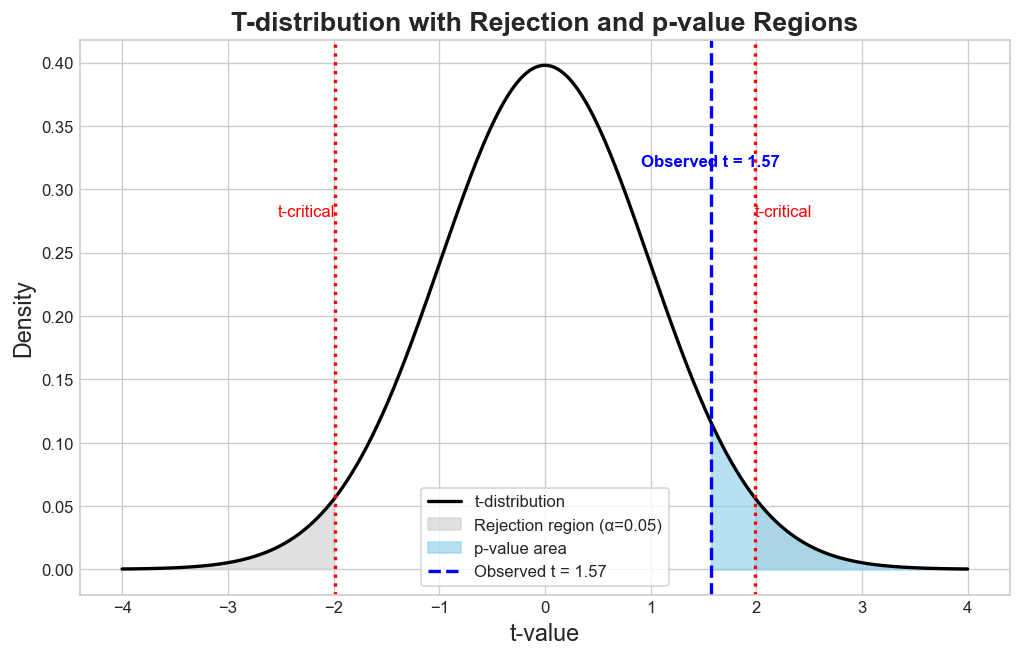

In [13]:
# Parameters
df = len(pre_bal) + len(post_bal) - 2  # degrees of freedom
alpha = 0.05
x = np.linspace(-4, 4, 1000)  # t-values
y = t.pdf(x, df)

# Critical values
t_crit = t.ppf(1 - alpha/2, df)

# Observed t-statistic (from your test)
t_obs = t_stat  

# Plot distribution
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10,6), dpi=120)
plt.plot(x, y, color="black", linewidth=2, label="t-distribution")

# Shade rejection regions (light gray)
plt.fill_between(x, y, where=(x > t_crit) | (x < -t_crit), 
                 color="lightgray", alpha=0.7, label="Rejection region (α=0.05)")

# Shade the p-value region (light blue)
if t_obs > 0:
    plt.fill_between(x, y, where=(x > t_obs), 
                     color="skyblue", alpha=0.6, label="p-value area")
else:
    plt.fill_between(x, y, where=(x < t_obs), 
                     color="skyblue", alpha=0.6, label="p-value area")

# Add observed t line
plt.axvline(t_obs, color="blue", linestyle="--", linewidth=2,
            label=f"Observed t = {t_obs:.2f}")

# Critical value lines
plt.axvline(-t_crit, color="red", linestyle=":", linewidth=2)
plt.axvline(t_crit, color="red", linestyle=":", linewidth=2)

# Titles and labels
plt.title("T-distribution with Rejection and p-value Regions", fontsize=16, fontweight="bold")
plt.xlabel("t-value", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Annotation text
plt.text(t_obs, max(y)*0.8, f"Observed t = {t_obs:.2f}", color="blue", 
         ha='center', fontsize=10, fontweight='bold')

plt.text(t_crit, max(y)*0.7, "t-critical", color="red", ha='left', fontsize=10)
plt.text(-t_crit, max(y)*0.7, "t-critical", color="red", ha='right', fontsize=10)

plt.legend(frameon=True, fontsize=10)
plt.show()

